In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.utils import resample
import snowflake.connector as sf
import geopandas as gpd
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# BDD

#### Test de connexion

In [ ]:
connection = sf.connect(
    user='LYNDA57',
    password='AZertyuiop1957@',
    account='zqdwlsk-zp08803',
    #warehouse='COMPUTE_WHE',
    database='TSUNAMI_RAW',
    schema='PUBLIC'
)

cursor = connection.cursor()

cursor.execute("SELECT * FROM TSUNAMI_RECORDS LIMIT 5")

for row in cursor:
    print(row)

cursor.close()
connection.close()

#### Récupération des données

In [ ]:
connection = sf.connect(
    user='LYNDA57',
    password='AZertyuiop1957@',
    account='zqdwlsk-zp08803',
    #warehouse='COMPUTE_WHE',
    database='TSUNAMI_RAW',
    schema='PUBLIC'
)

cursor = connection.cursor()

cursor.execute("SELECT * FROM TSUNAMI_RECORDS LIMIT 0")

columns = [col[0] for col in cursor.description]

batch_size = 1000
offset = 0

all_data = []

while True:
    query = f"SELECT * FROM TSUNAMI_RECORDS LIMIT {batch_size} OFFSET {offset}"
    cursor.execute(query)

    
    batch_data = cursor.fetchall()

    if not batch_data:
        break 

    all_data.extend(batch_data)

    offset += batch_size
    print(f"Batch récupéré, lignes {offset - batch_size} à {offset - 1}")

df = pd.DataFrame(all_data, columns=columns)

#df.to_csv('tsunami_data.csv', index=False)

cursor.close()
connection.close()

# Traitement des données

In [ ]:
#df = pd.read_csv("Eartquakes-1990-2023.csv") #si non appel à la base
data = df.copy()

In [9]:
df.head()

,time,place,status,tsunami,significance,data_type,magnitudo,state,longitude,latitude,depth,date
0,631153353990,"12 km NNW of Meadow Lakes, Alaska",reviewed,0,96,earthquake,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,"14 km S of Volcano, Hawaii",reviewed,0,31,earthquake,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,"7 km W of Cobb, California",reviewed,0,19,earthquake,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,"11 km E of Mammoth Lakes, California",reviewed,0,15,earthquake,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,"16km N of Fillmore, CA",reviewed,0,134,earthquake,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00


In [10]:
df.columns

Index(['time', 'place', 'status', 'tsunami', 'significance', 'data_type',
       'magnitudo', 'state', 'longitude', 'latitude', 'depth', 'date'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3445751 entries, 0 to 3445750
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time          int64  
 1   place         object 
 2   status        object 
 3   tsunami       int64  
 4   significance  int64  
 5   data_type     object 
 6   magnitudo     float64
 7   state         object 
 8   longitude     float64
 9   latitude      float64
 10  depth         float64
 11  date          object 
dtypes: float64(4), int64(3), object(5)
memory usage: 315.5+ MB


#### Suppression des variables inutiles

In [ ]:
df = df.drop(columns=['date'])

df = df.drop(columns=["place"])

df = df[df['data_type'] == 'earthquake'].copy()
df = df.drop(columns=['data_type'])

In [13]:
top = df['state'].value_counts().nlargest(50).index
df['state'] = df['state'].where(df['state'].isin(top), other='other')

#### Ajout de la variable on_land

In [14]:
land = gpd.read_file("ne_110m_land/ne_110m_land.shp")

df['geometry'] = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry')

gdf['on_land'] = gdf['geometry'].apply(lambda x: land.contains(x).any())

gdf

,time,status,tsunami,significance,magnitudo,state,longitude,latitude,depth,geometry,on_land
0,631153353990,reviewed,0,96,2.50,Alaska,-149.669200,61.730200,30.100,POINT (-149.6692 61.7302),True
1,631153491210,reviewed,0,31,1.41,Hawaii,-155.212333,19.317667,6.585,POINT (-155.21233 19.31767),True
2,631154083450,reviewed,0,19,1.11,California,-122.806167,38.821000,3.220,POINT (-122.80617 38.821),True
3,631155512130,reviewed,0,15,0.98,California,-118.846333,37.664333,-0.584,POINT (-118.84633 37.66433),True
4,631155824490,reviewed,0,134,2.95,California,-118.934000,34.546000,16.122,POINT (-118.934 34.546),True
...,...,...,...,...,...,...,...,...,...,...,...
3445746,1690626851941,reviewed,0,326,4.60,Japan,139.940200,36.350700,83.039,POINT (139.9402 36.3507),True
3445747,1690626975715,automatic,0,44,1.70,Alaska,-153.729900,57.790100,24.400,POINT (-153.7299 57.7901),True
3445748,1690627215940,automatic,0,90,2.42,B.C.,-115.296833,32.233167,1.770,POINT (-115.29683 32.23317),True
3445749,1690628146040,automatic,0,16,1.03,California,-122.800499,38.827499,1.720,POINT (-122.8005 38.8275),True


#### Calcul de la distance avec la côte la plus proche

In [ ]:
gdf_eq = gpd.GeoDataFrame(
    gdf,
    geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude),
    crs='EPSG:4326'
)

coastline = gpd.read_file("ne_10m_coastline/ne_10m_coastline.shp")

gdf_eq = gdf_eq.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)

gdf_eq['distance_to_coast_km'] = gdf_eq.geometry.apply(
    lambda point: coastline.distance(point).min() / 1000
)

#### Traitement des variables catégorielles

In [ ]:
categorical_cols = ['status', 'state', 'on_land']
numeric_cols = ['time', 'significance', 'magnitudo', 'longitude', 'latitude', 'depth']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cats = encoder.fit_transform(gdf[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(), index=gdf.index)

df_model = pd.concat([gdf[numeric_cols], encoded_cat_df], axis=1)

df_model

,time,significance,magnitudo,longitude,latitude,depth,tsunami,status_AUTOMATIC,status_MANUAL,status_REVIEWED,...,state_Central Alaska,state_Fiji region,state_Kermadec Islands region,state_Northern California,state_South Sandwich Islands region,state_Southern Alaska,state_other,state_south of the Fiji Islands,on_land_False,on_land_True
0,631153353990,96,2.50,-149.669200,61.730200,30.100,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,631153491210,31,1.41,-155.212333,19.317667,6.585,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,631154083450,19,1.11,-122.806167,38.821000,3.220,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,631155512130,15,0.98,-118.846333,37.664333,-0.584,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,631155824490,134,2.95,-118.934000,34.546000,16.122,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3445746,1690626851941,326,4.60,139.940200,36.350700,83.039,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3445747,1690626975715,44,1.70,-153.729900,57.790100,24.400,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3445748,1690627215940,90,2.42,-115.296833,32.233167,1.770,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3445749,1690628146040,16,1.03,-122.800499,38.827499,1.720,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [120]:
df_model['distance_to_coast_km'] = gdf_eq['distance_to_coast_km']
df_model['distance_to_coast_km']

0           55.655375
1            6.849158
2           63.423485
3          293.075223
4           53.789606
              ...    
3445746     70.078243
3445747     17.407584
3445748     45.535674
3445749     64.540916
3445750     45.812137
Name: distance_to_coast_km, Length: 3361846, dtype: float64

### Correlation

In [48]:
df_corr = pd.concat([df_model, gdf['tsunami']], axis=1)

df_corr.corr(numeric_only=True)['tsunami'].sort_values(ascending=False)

tsunami                                  1.000000
state_Alaska                             0.004557
latitude                                 0.003211
state_Puerto Rico                        0.002235
state_Aleutian Islands                   0.001797
distance_to_coast_km                     0.001356
depth                                    0.001094
state_Fiji Region                        0.000980
state_Oklahoma                           0.000895
state_Nevada                             0.000681
state_Wyoming                            0.000652
state_Montana                            0.000437
state_Japan Region                       0.000437
state_Hawaii                             0.000385
state_Timor Leste                        0.000342
state_U.S. Virgin Islands                0.000285
state_Canada                             0.000276
state_Afghanistan                        0.000230
state_Solomon Islands                    0.000204
state_Dominican Republic                 0.000189


C:\Users\Nicol\AppData\Local\Temp\ipykernel_15540\2365547790.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


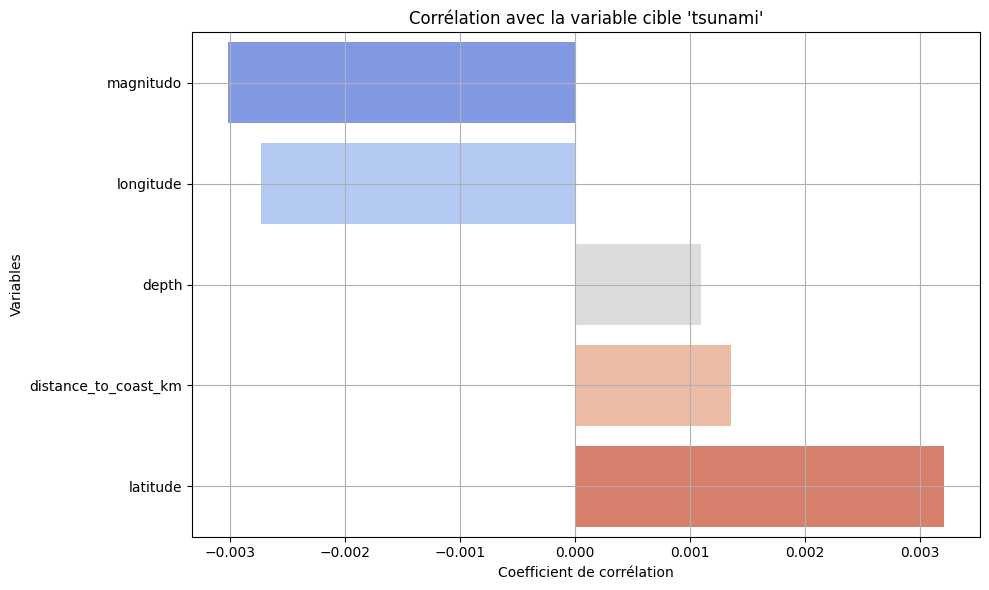

In [53]:
df_filtered = df_corr.loc[:, ~df_corr.columns.str.startswith('state')]

correlations = df_filtered.corr(numeric_only=True)['tsunami'].drop('tsunami').sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title("Corrélation avec la variable cible 'tsunami'")
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Variables")
plt.grid(True)
plt.tight_layout()
plt.show()

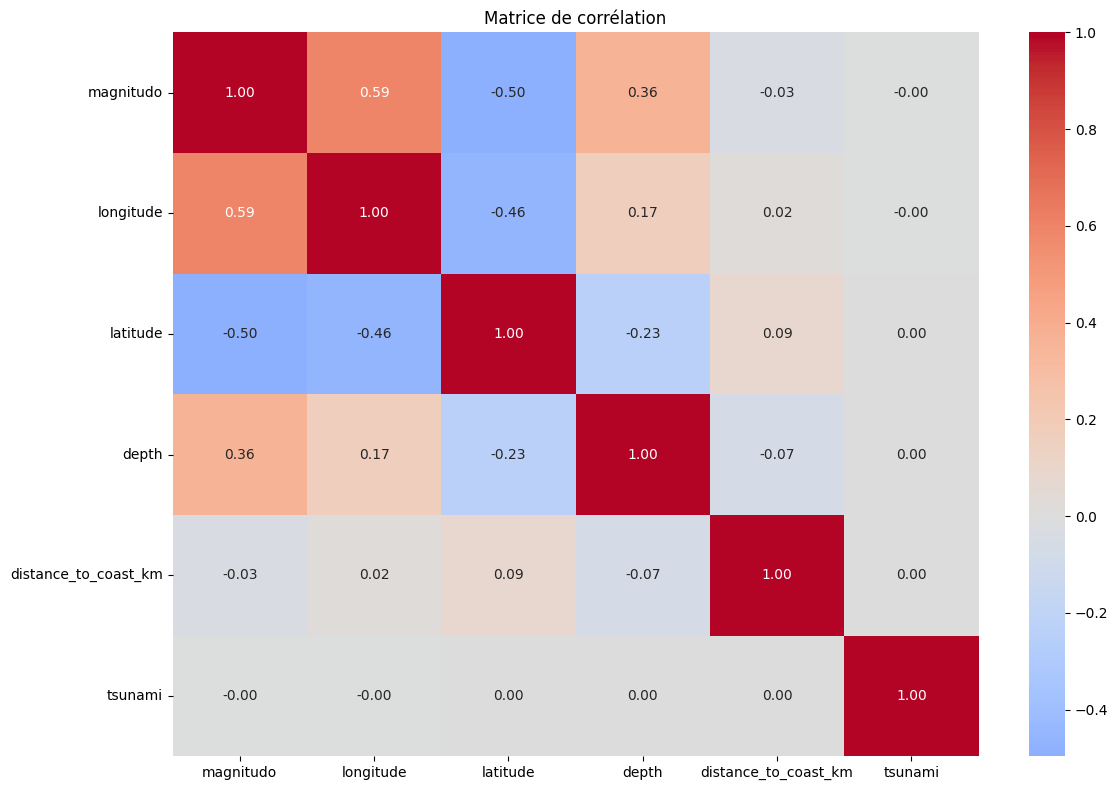

In [ ]:
corr_matrix = df_filtered.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

In [ ]:
X = df_model.drop(columns=['tsunami'])
y = df_model['tsunami']

model = make_pipeline(StandardScaler(), LassoCV(cv=5))
model.fit(X, y)

coefs = model.named_steps['lassocv'].coef_
selected_features = X.columns[coefs != 0]

print("Colonnes sélectionnées automatiquement par Lasso :")
print(selected_features)

Colonnes sélectionnées automatiquement par Lasso :
Index(['time', 'significance', 'magnitudo', 'longitude', 'latitude', 'depth',
       'status_REVIEWED', 'status_automatic', 'state_ Afghanistan',
       'state_ Alaska', 'state_ Aleutian Islands', 'state_ Argentina',
       'state_ B.C.', 'state_ California', 'state_ Canada', 'state_ China',
       'state_ Dominican Republic', 'state_ Fiji', 'state_ France',
       'state_ Greece', 'state_ Hawaii', 'state_ Indonesia', 'state_ Iran',
       'state_ Japan', 'state_ Japan region', 'state_ Mexico',
       'state_ Montana', 'state_ Nevada', 'state_ New Zealand',
       'state_ Oklahoma', 'state_ Papua New Guinea', 'state_ Peru',
       'state_ Philippines', 'state_ Puerto Rico', 'state_ Russia',
       'state_ Solomon Islands', 'state_ Spain', 'state_ Tonga',
       'state_ Turkey', 'state_ Utah', 'state_ Vanuatu', 'state_ Washington',
       'state_ Wyoming', 'state_California',
       'state_California-Nevada border region', 'state_Centra

### RFC

In [17]:
df_model = df_model.drop(columns="tsunami")

In [ ]:
X = df_model
y = gdf['tsunami']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    840080
           1       0.48      0.05      0.10       382

    accuracy                           1.00    840462
   macro avg       0.74      0.53      0.55    840462
weighted avg       1.00      1.00      1.00    840462



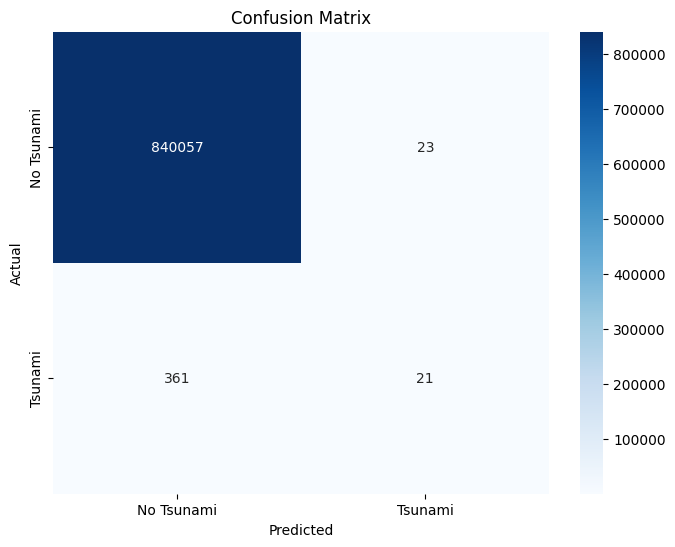

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tsunami', 'Tsunami'], yticklabels=['No Tsunami', 'Tsunami'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### SMOTE

In [20]:
X = df_model
y = gdf['tsunami']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 554, in run
    with P

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    840080
           1       0.29      0.49      0.36       382

    accuracy                           1.00    840462
   macro avg       0.64      0.75      0.68    840462
weighted avg       1.00      1.00      1.00    840462



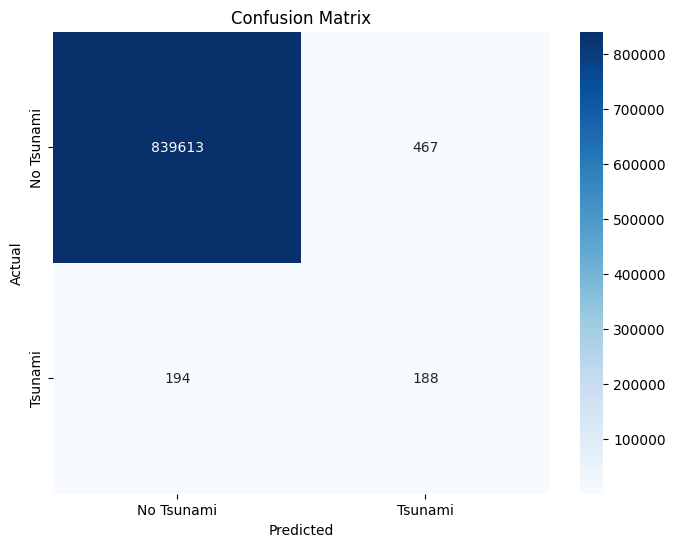

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tsunami', 'Tsunami'], yticklabels=['No Tsunami', 'Tsunami'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Oversampling

In [22]:
X = df_model
y = gdf['tsunami']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

model_ros = RandomForestClassifier(random_state=42, n_estimators=100)
model_ros.fit(X_train_ros, y_train_ros)

y_pred_ros = model_ros.predict(X_test)
print(classification_report(y_test, y_pred_ros))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    840080
           1       0.40      0.15      0.22       382

    accuracy                           1.00    840462
   macro avg       0.70      0.58      0.61    840462
weighted avg       1.00      1.00      1.00    840462



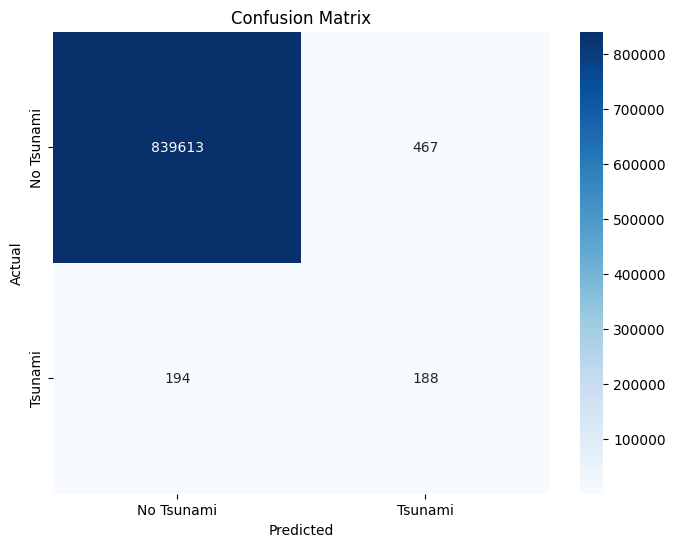

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tsunami', 'Tsunami'], yticklabels=['No Tsunami', 'Tsunami'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Undersampling

#### 1ère méthode

In [36]:
X = df_model
y = gdf['tsunami']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

test_df = pd.concat([X_train, y_train], axis=1)

df_majority = test_df[test_df['tsunami'] == 0]
df_minority = test_df[test_df['tsunami'] == 1]

df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced.drop(columns=['tsunami'])
y = df_balanced['tsunami']

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X, y)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75    840080
           1       0.00      0.31      0.00       382

    accuracy                           0.60    840462
   macro avg       0.50      0.46      0.38    840462
weighted avg       1.00      0.60      0.75    840462



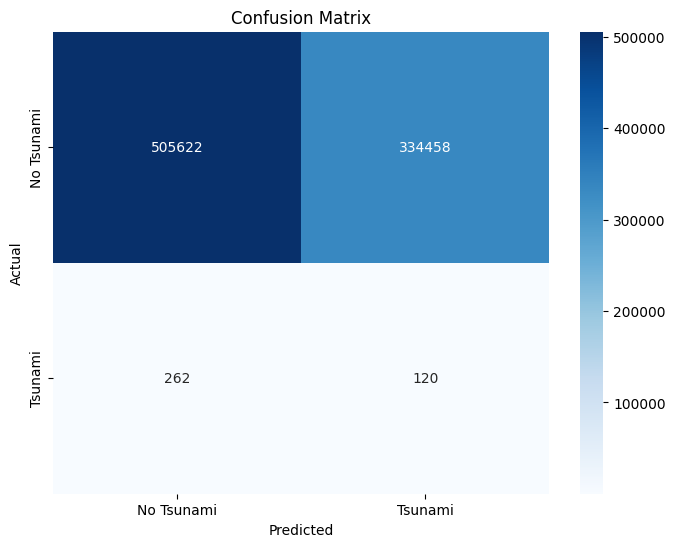

In [27]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tsunami', 'Tsunami'], yticklabels=['No Tsunami', 'Tsunami'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### 2nd méthode

In [29]:
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced.drop(columns=['tsunami'])
y = df_balanced['tsunami']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.42      0.49       229
         1.0       0.55      0.71      0.62       229

    accuracy                           0.57       458
   macro avg       0.57      0.57      0.56       458
weighted avg       0.57      0.57      0.56       458



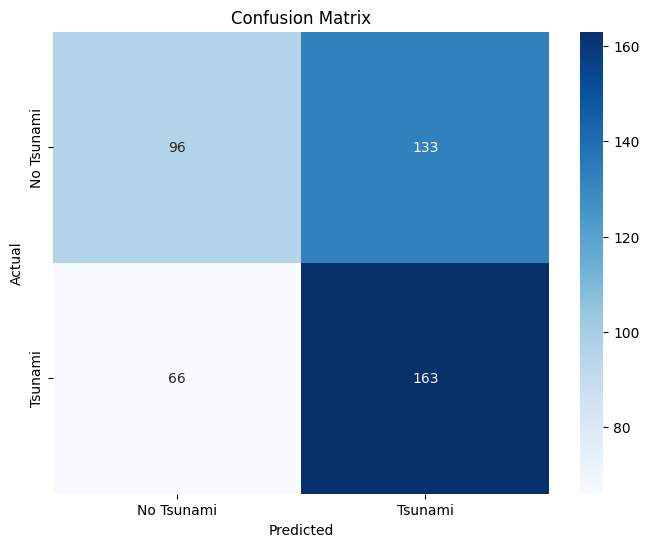

In [30]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tsunami', 'Tsunami'], yticklabels=['No Tsunami', 'Tsunami'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Autres modèles

In [54]:
X = df_model
y = gdf['tsunami']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = xgb.XGBClassifier()

model.fit(X_train_ros, y_train_ros)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    840080
           1       0.17      0.84      0.28       382

    accuracy                           1.00    840462
   macro avg       0.58      0.92      0.64    840462
weighted avg       1.00      1.00      1.00    840462



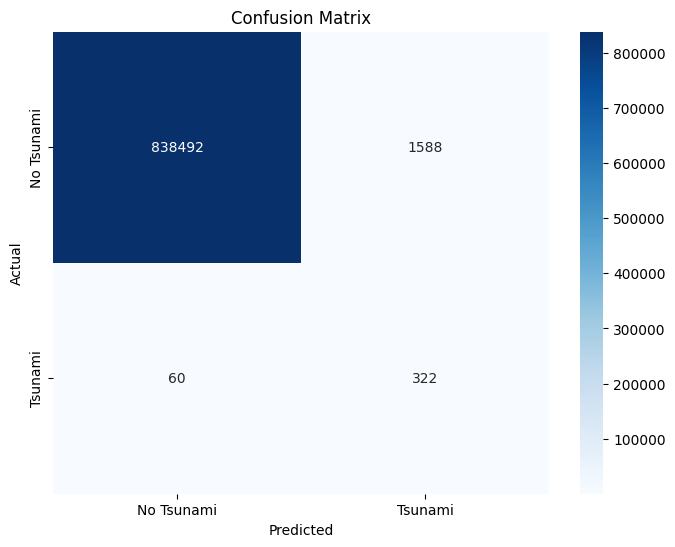

In [55]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tsunami', 'Tsunami'], yticklabels=['No Tsunami', 'Tsunami'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model = SVC()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tsunami', 'Tsunami'], yticklabels=['No Tsunami', 'Tsunami'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()